## Missing Fingers

In [1]:
import warnings
from typing import List

import pyro
import pyro.distributions as dist
import torch

import probability_on_trial as pot

Building Core model:

In [2]:
pyro.set_rng_seed(42)

import matplotlib.pyplot as plt 


pr_identity =   1/300   # high prior at this point, given other circumstantial information (tip from a woman, travel pattern, etc)
rmp_fingers_sweden = 2 / 20000 # RMP for Sweden
pr_fingers_match_if_isis = 2 / 5000 # RMP for ISIS memebers; for now a precise number 


def swedish_fingers_guilt_precise_core(
    pr_identity: float = pr_identity, 
    rmp_fingers_sweden: float =rmp_fingers_sweden,  
    pr_fingers_match_if_isis: float = pr_fingers_match_if_isis,  
    num_particles=3e7,  
):

    with pyro.plate("particles", size=num_particles):

        
        guilty = pyro.sample("guilty", dist.Bernoulli(pr_identity))



        fingers_match_sweden = pyro.sample(
            "fingers_match_sweden",
            # if guilty then 1
            # if not guilty then sample with probability rmp
            dist.Bernoulli(guilty * 1 + (1 - guilty) * (rmp_fingers_sweden)),
        )

        fingers_match_isis =   pyro.sample("fingers_match_isis",
            dist.Bernoulli(
                guilty * 1
                + (1 - guilty) * pr_fingers_match_if_isis
                                ),
        )
        

    # Evidence mask 1: fingers match
    evidence_mask_fingers_sweden = (fingers_match_sweden).bool()
    guilty_masked_fingers_sweden = pyro.deterministic(
        "guilty_masked_fingers_sweden",
        torch.where(evidence_mask_fingers_sweden, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_sweden = pyro.deterministic(
        "posterior_guilty_fingers_sweden", torch.nanmean(guilty_masked_fingers_sweden, axis=0)
    )

    # Mask 2: fingers match, isis
    evidence_mask_fingers_isis = (fingers_match_isis).bool()
    

    guilty_masked_fingers_isis = pyro.deterministic(
        "guilty_masked_fingers_isis",
        torch.where(evidence_mask_fingers_isis, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_isis = pyro.deterministic(
        "posterior_guilty_fingers_isis"        ,
        torch.nanmean(guilty_masked_fingers_isis, axis=0),
    )

    return {
        "posterior_guilty_fingers_sweden": posterior_guilty_fingers_sweden,
        "posterior_guilty_fingers_isis": posterior_guilty_fingers_isis,
    }




pyro.set_rng_seed(422323)
outcome = swedish_fingers_guilt_precise_core()
print(outcome)

posterior_sweden = outcome["posterior_guilty_fingers_sweden"]
posterior_isis = outcome["posterior_guilty_fingers_isis"]

{'posterior_guilty_fingers_sweden': tensor(0.9709), 'posterior_guilty_fingers_isis': tensor(0.8936)}


In [3]:
# requires pyro 1.9.1
#pyro.render_model(swedish_fingers_guilt_model, render_deterministic=True)

In [9]:
posterior_guilt_sweden = torch.tensor(
    [
        1 - posterior_sweden,
        posterior_sweden,]
)

posterior_guilt_isis = torch.tensor(
    [
    1 - posterior_isis,
        posterior_isis
    ]
)

prior_guilt = torch.tensor([1 - pr_identity, pr_identity])


print("posterior_guilt_no_isis_info", posterior_guilt_sweden)
print("posterior_guilt_isis", posterior_guilt_isis)


print(
"sweden", pot.weight(posterior_guilt_sweden, prior_guilt)
)

print(
"isis", pot.weight(posterior_guilt_isis, prior_guilt)
)

print(posterior_guilt_isis)
print(prior_guilt)


posterior_guilt_no_isis_info tensor([0.0291, 0.9709])
posterior_guilt_isis tensor([0.1064, 0.8936])
sweden tensor(0.7035)
isis tensor(0.3123)
tensor([0.1064, 0.8936])
tensor([0.9967, 0.0033])


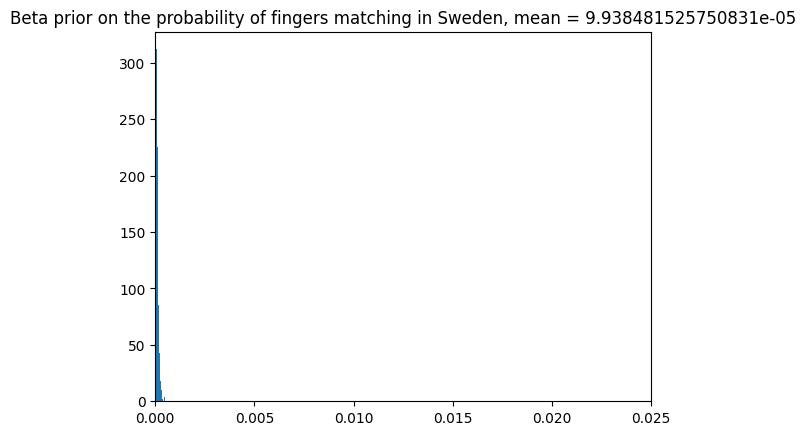

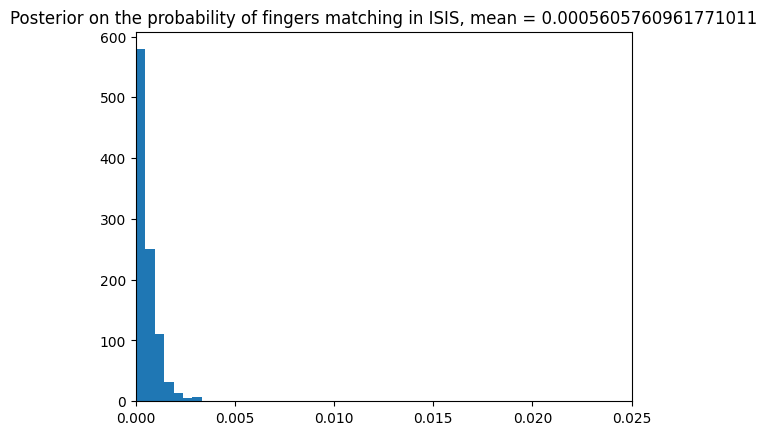

In [5]:
with pyro.plate("samples", 1000):
    probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))

plt.hist(probs_sweden)
plt.title(f"Beta prior on the probability of fingers matching in Sweden, mean = {probs_sweden.mean()}")
plt.xlim(0,.025)
plt.show()

with pyro.plate("multipliers", 1000):
    multiplier = pyro.sample("probs_isis", dist.Uniform(1, 10))
    probs_isis = (probs_sweden * multiplier).clamp(0, 1)

plt.hist(probs_isis)
plt.title(f"Posterior on the probability of fingers matching in ISIS, mean = {probs_isis.mean()}")
plt.xlim(0,.025)
plt.show()

In [11]:
bayesian_samples = 2

def bayesian_missing_fingers():
    outcomes = []

    with pyro.plate("bayesia_samples", bayesian_samples):
        probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))
        multiplier = pyro.sample("probs_isis", dist.Uniform(1, 10))
        probs_isis = (probs_sweden * multiplier).clamp(0, 1)

        outcomes = swedish_fingers_guilt_precise_core(rmp_fingers_sweden= probs_sweden, 
                                                      pr_fingers_match_if_isis=probs_isis,
                                                      num_particles=3e5)

# TODO weigths should be refactor to allow for batched computations, then this loop should be replaced by tw single calls to pot.weight
        sweden_weights = []
        isis_weights = []
        for i in range(bayesian_samples):
            sweden_distro = torch.tensor([1 - outcomes['posterior_guilty_fingers_sweden'][i],  outcomes['posterior_guilty_fingers_sweden'][i]])
            isis_distro = torch.tensor([1 - outcomes['posterior_guilty_fingers_isis'][i], outcomes['posterior_guilty_fingers_isis'][i]])

            sweden_weights.append(pot.weight(sweden_distro, prior_guilt))
            isis_weights.append(pot.weight(isis_distro, prior_guilt))

    outcomes['sweden_weights'] = sweden_weights 
    outcomes['isis_weights'] = isis_weights


    return outcomes


bayesian_samples = bayesian_missing_fingers()

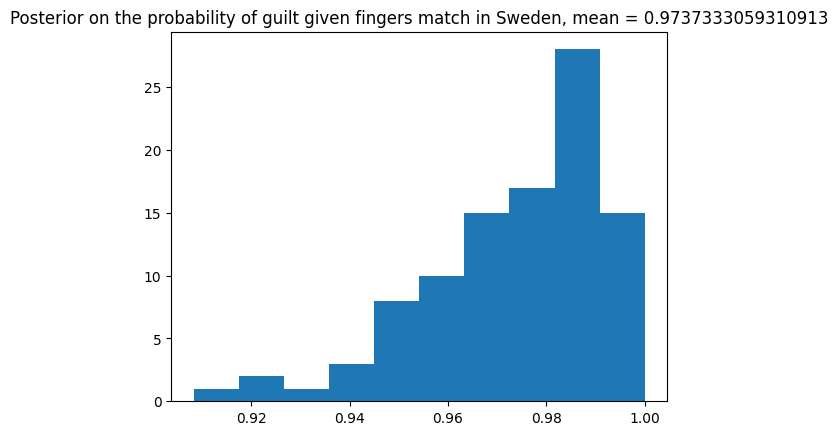

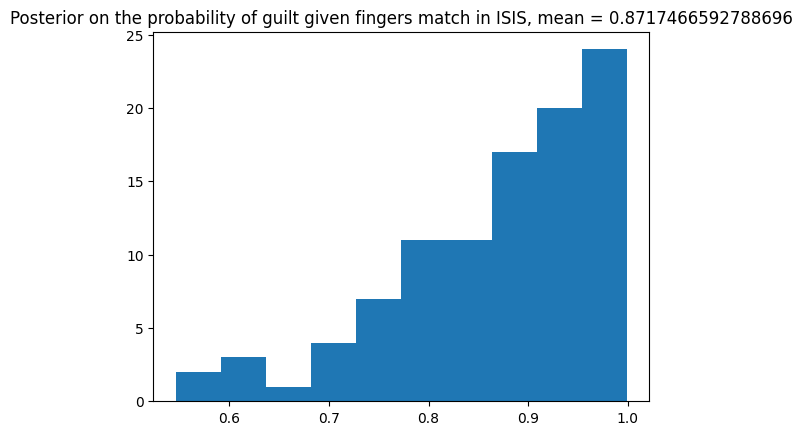

In [ ]:
plt.hist(bayesian_samples["posterior_guilty_fingers_sweden"], bins = 100)
plt.title(f"Posterior on the probability of guilt given fingers match in Sweden, mean = {bayesian_samples['posterior_guilty_fingers_sweden'].mean()}")
plt.show()


plt.hist(bayesian_samples["posterior_guilty_fingers_isis"], bins = 100)
plt.title(f"Posterior on the probability of guilt given fingers match in ISIS, mean = {bayesian_samples['posterior_guilty_fingers_isis'].mean()}")
plt.show()


In [ ]:
print(bayesian_samples)

plt.hist(bayesian_samples['sweden_weights'], bins = 100)
plt.title(f"Weights of the posterior on guilt given Swedish likelihood, mean = {torch.tensor(bayesian_samples['sweden_weights']).mean()}")
plt.show()

plt.hist(bayesian_samples['isis_weights'], bins = 100)
plt.title(f"Weights of the posterior on guilt given ISIS likelihood, mean = {torch.tensor(bayesian_samples['isis_weights']).mean()}")
plt.show()



{'posterior_guilty_fingers_sweden': tensor([0.9634, 0.9968]), 'posterior_guilty_fingers_isis': tensor([0.9335, 0.9585]), 'sweden_weights': [tensor(0.6506), tensor(0.9476)], 'isis_weights': [tensor(0.4799), tensor(0.6191)]}
